Importing the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score,r2_score
from time import time
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from datetime import datetime, date
import calendar
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Loading the dataset into a python dataframe

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/ML Project/train.csv')
display(df.head())
display(df.tail())

Mounted at /content/drive


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


#### Dataset Exploration

In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Split the data into Train and Test - The dataset is split in such a way that the training dataset contains data from the year 2013 to 2016. WHile, the testing dataset contains data for the year 2017

In [6]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')

train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

In [7]:
print(train)
print(test)

            date  store  item  sales  year
0     2013-01-01      1     1     13  2013
1     2013-01-02      1     1     11  2013
2     2013-01-03      1     1     14  2013
3     2013-01-04      1     1     13  2013
4     2013-01-05      1     1     10  2013
...          ...    ...   ...    ...   ...
1456  2016-12-27      1     1     10  2016
1457  2016-12-28      1     1     16  2016
1458  2016-12-29      1     1     21  2016
1459  2016-12-30      1     1     24  2016
1460  2016-12-31      1     1     14  2016

[1461 rows x 5 columns]
            date  store  item  sales  year
1461  2017-01-01      1     1     19  2017
1462  2017-01-02      1     1     15  2017
1463  2017-01-03      1     1     10  2017
1464  2017-01-04      1     1     16  2017
1465  2017-01-05      1     1     14  2017
...          ...    ...   ...    ...   ...
1821  2017-12-27      1     1     14  2017
1822  2017-12-28      1     1     19  2017
1823  2017-12-29      1     1     15  2017
1824  2017-12-30      1     1

#### Setting up a benchmark (Before preprocessing the data)

Benchmark 1 - The approach followed in this is a very naive forcasting method where we are just taking an average of that particular day for each year and then predicting the value of the next year same day as that average value.
For Example:
Predicted inventory requirement value for Jan 1st 2017 would be Average value of Jan 1st Sales value of the years (2013, 2014, 2015 and 2016)


In [8]:
train["month_day"] = train.date.map(lambda x:str(x)[5:12])

In [9]:
train = train[train["month_day"] != '02-29']

In [10]:
X_Pred = train.groupby("month_day").sales.mean().to_frame()

In [11]:
X_Test = test[["sales"]]

Benchmark 1 - MAPE value to determine accuracy of the model

In [12]:
mape(X_Pred, X_Test)

0.3029780598276817

#### Feature Engineering

To get better results first try to introduce a few other attributes which might help the model predict better. To do so we perform Feature Engineering

In [13]:
#Splitting the Date coumn into Year, Month and Day respectively
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [14]:
#Adding weekend column
def weekend_or_weekday(year,month,day):

    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [15]:
#Adding columns to capture cyclic nature of the data (if any)
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025


In [16]:
#Adding column to identify the day of the week
def which_day(year, month, day):

    d = datetime(year,month,day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
                                                      x['month'],
                                                      x['day']),
                                   axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025,5


In [17]:
df.drop('date', axis=1, inplace=True)

#### Exploratory Data Analysis

In [18]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

From here we can conclude that there are 10 unique stores and they sell 50 different products

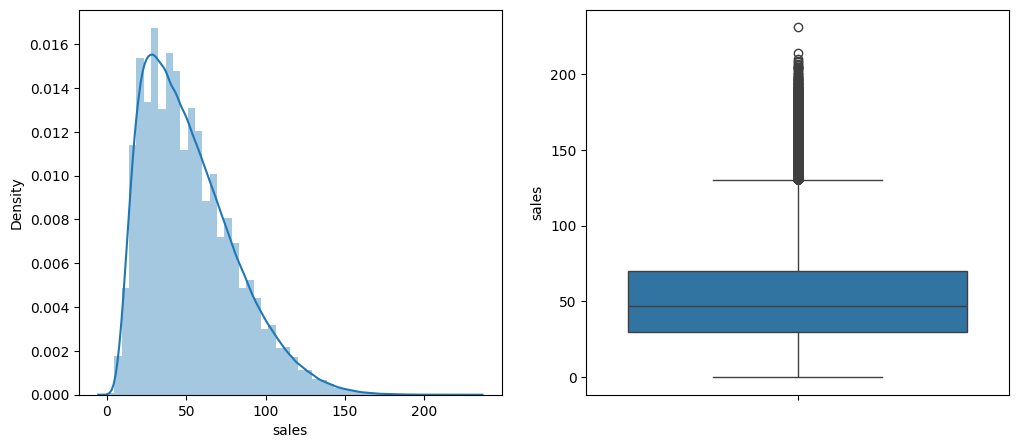

In [19]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()


As per the above graph we can conclude that the values above unit sales > 140 are the outliers. In our analysis we remove them as we want a clean prediction and these values should not skew the results

In [20]:
df = df[df['sales']<140]

#### Benchmark 2: Setting up this benchmark after preprocessing the data

Splitting the dataset into training and testing after preprocessing

In [21]:
train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

X_train = train.drop(['sales', 'year'], axis=1)

X_test = test.drop(['sales', 'year'], axis=1)

y_train = train['sales'].values

y_test = test['sales'].values

X_train.shape, X_test.shape

((1461, 8), (365, 8))

In [22]:
X_train

,store,item,month,day,weekend,m1,m2,weekday
0,1,1,1,1,0,5.000000e-01,0.866025,1
1,1,1,1,2,0,5.000000e-01,0.866025,2
2,1,1,1,3,0,5.000000e-01,0.866025,3
3,1,1,1,4,0,5.000000e-01,0.866025,4
4,1,1,1,5,1,5.000000e-01,0.866025,5
...,...,...,...,...,...,...,...,...
1456,1,1,12,27,0,-2.449294e-16,1.000000,1
1457,1,1,12,28,0,-2.449294e-16,1.000000,2
1458,1,1,12,29,0,-2.449294e-16,1.000000,3
1459,1,1,12,30,0,-2.449294e-16,1.000000,4


In [23]:
# Standardization the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training the dataset on different models to check the results and use the best one for prediction

In [24]:
regressors = [
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    XGBRegressor(),
    Lasso(),
    Ridge()
]

In [25]:
threshold = 15
y_train_01 = np.where(y_train > threshold, 1, 0)
y_test_01 = np.where(y_test > threshold, 1, 0)

KNeighborsRegressor()
	Training time: 0.003s
	Prediction time: 0.005s
	Explained variance: 0.04583591005936627
	Mean absolute percentage error: 0.9670360102016088
	R2 score: -9.511764255332665


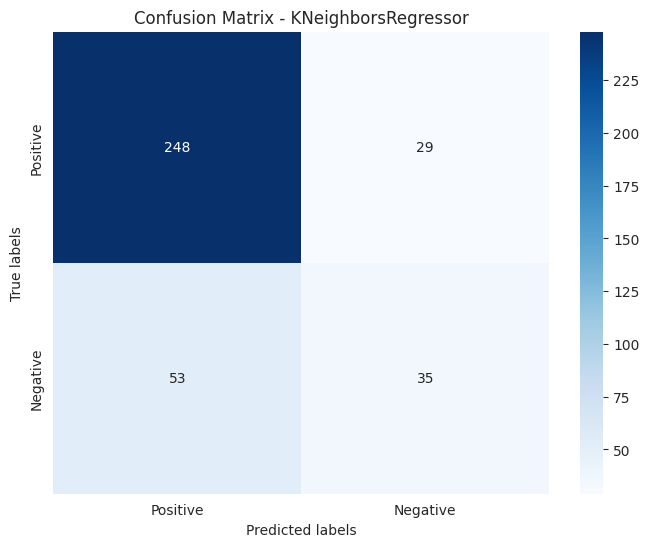

Classification Report:


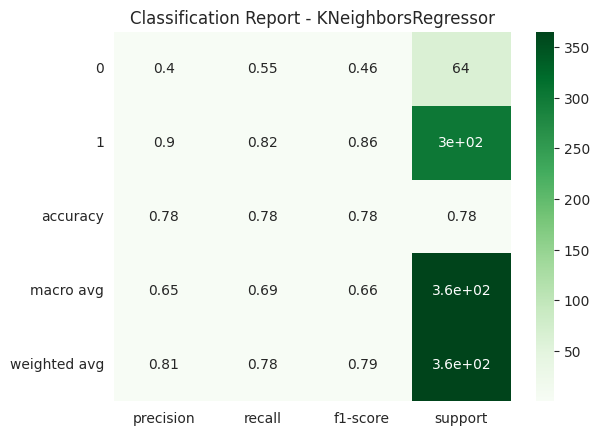


ExtraTreesRegressor()
	Training time: 0.325s
	Prediction time: 0.008s
	Explained variance: 0.03983190313232943
	Mean absolute percentage error: 0.9661454377039552
	R2 score: -9.512475074826504


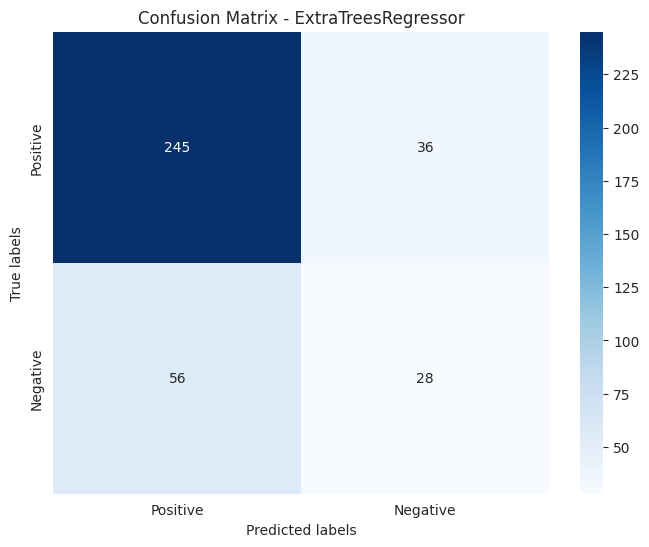

Classification Report:


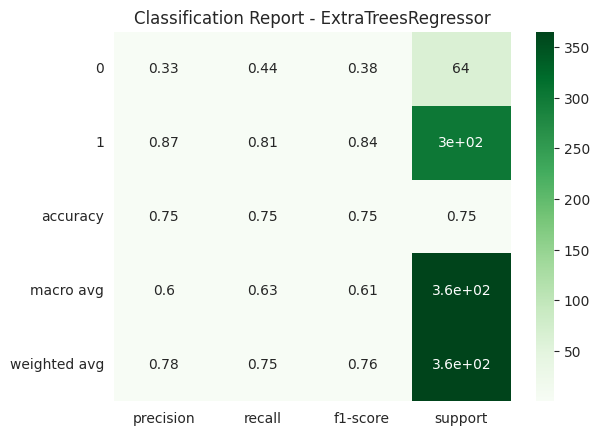


RandomForestRegressor()
	Training time: 0.478s
	Prediction time: 0.012s
	Explained variance: 0.042449801931213615
	Mean absolute percentage error: 0.9663187893165268
	R2 score: -9.508857245382053


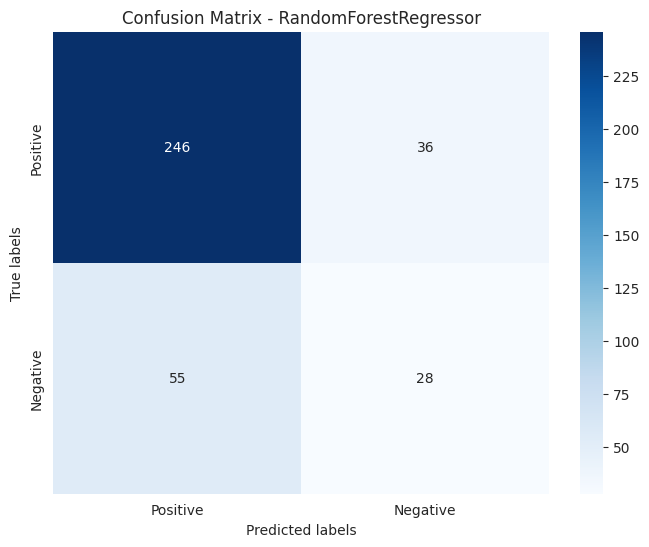

Classification Report:


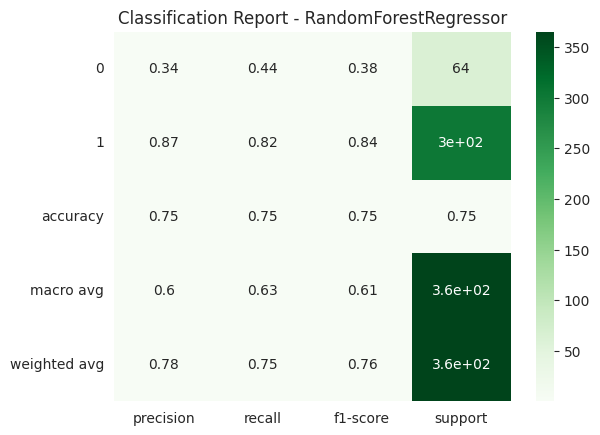


GradientBoostingRegressor()
	Training time: 0.176s
	Prediction time: 0.001s
	Explained variance: 0.04746637471716597
	Mean absolute percentage error: 0.9672179368078285
	R2 score: -9.513703714762206


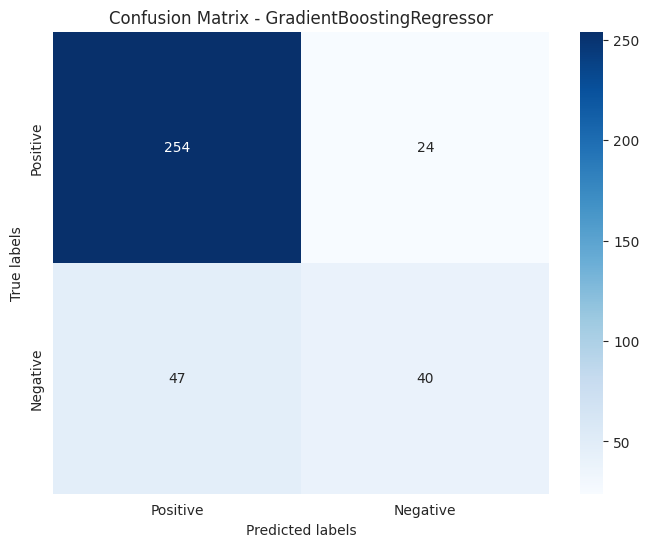

Classification Report:


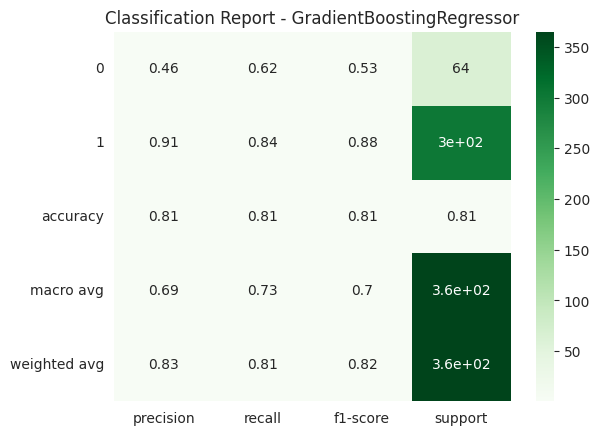


DecisionTreeRegressor()
	Training time: 0.004s
	Prediction time: 0.000s
	Explained variance: 0.040118153176308735
	Mean absolute percentage error: 0.9662973078838418
	R2 score: -9.511627881633856


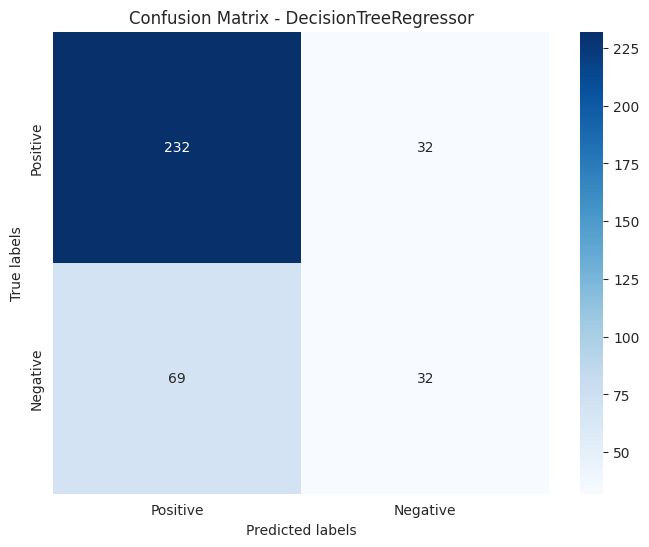

Classification Report:


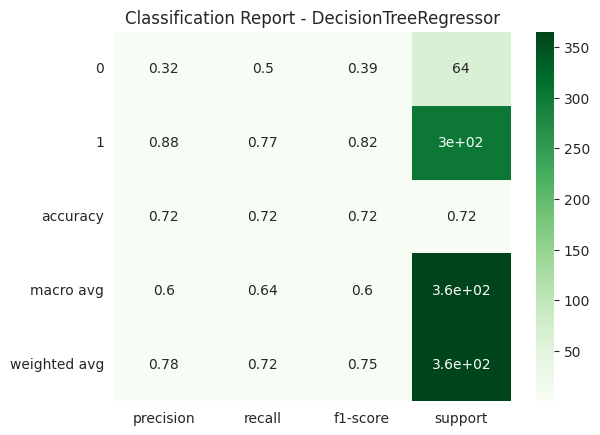


LinearRegression()
	Training time: 0.002s
	Prediction time: 0.000s
	Explained variance: 0.045297139414438026
	Mean absolute percentage error: 0.9668184281768291
	R2 score: -9.51550084383711


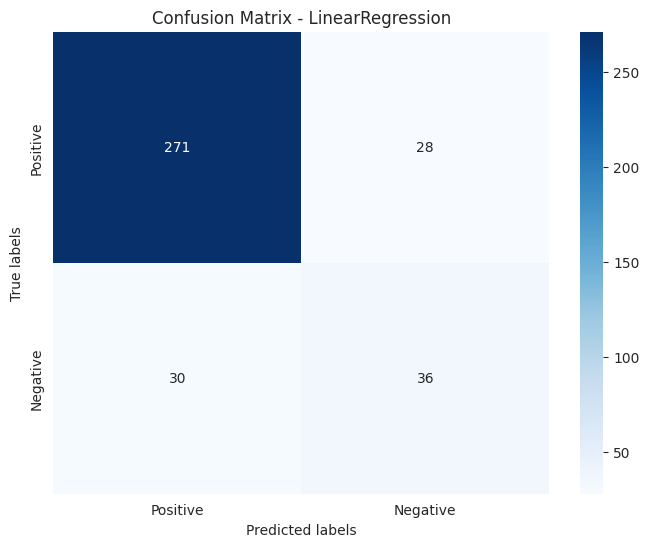

Classification Report:


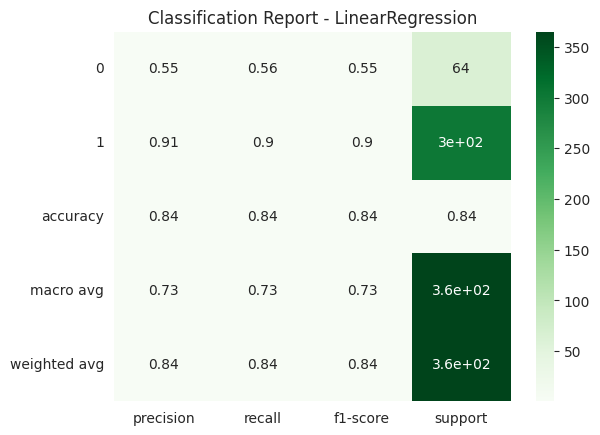


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
	Training time: 0.769s
	Prediction time: 0.002s
	Explained variance: 0.04258451912671679
	Mean absolute percentage error: 0.9657454827691347
	R2 score: -9.494905073865555


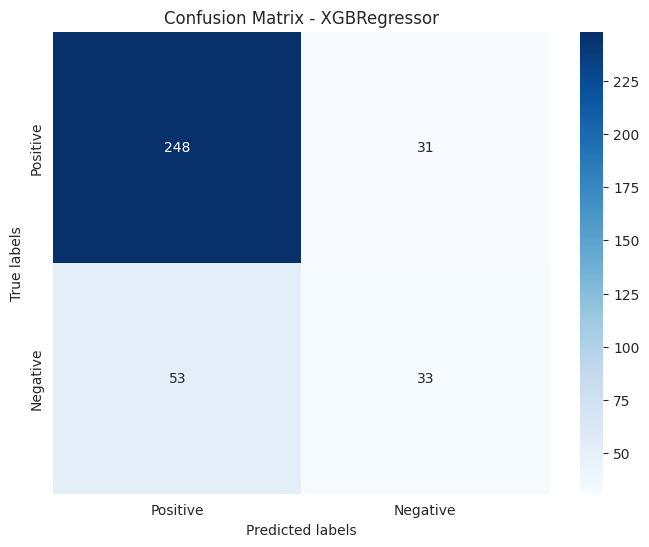

Classification Report:


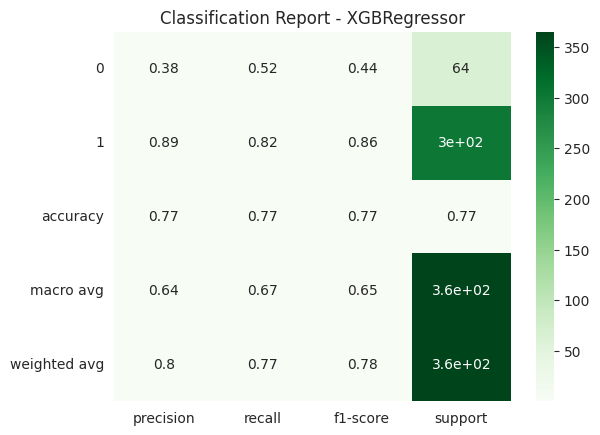


Lasso()
	Training time: 0.013s
	Prediction time: 0.000s
	Explained variance: 3.3306690738754696e-16
	Mean absolute percentage error: 0.9638886062236937
	R2 score: -9.561328550237455


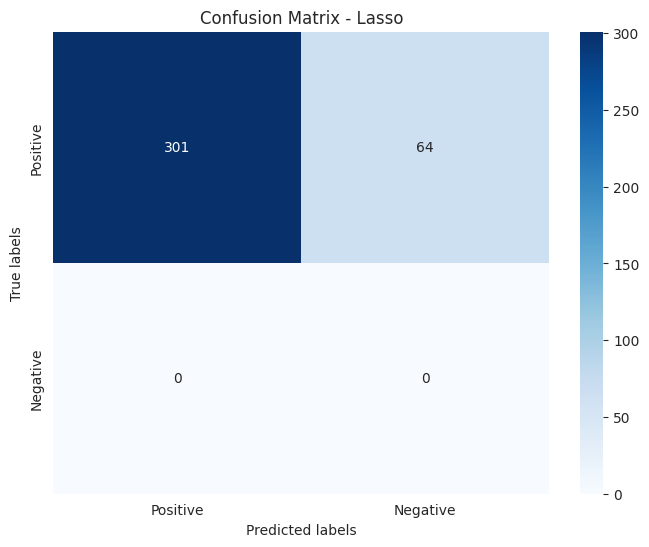

Classification Report:


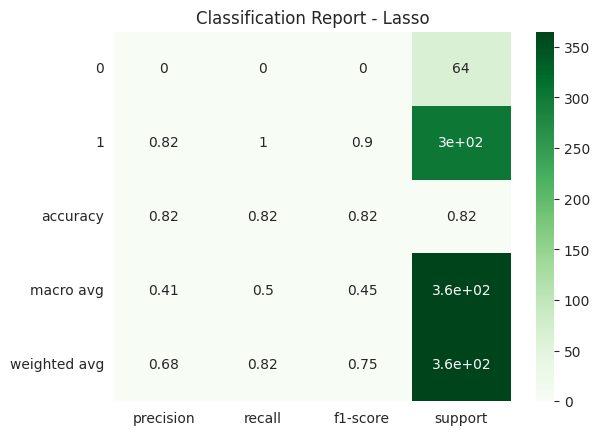


Ridge()
	Training time: 0.009s
	Prediction time: 0.000s
	Explained variance: 0.04526704260837244
	Mean absolute percentage error: 0.9668162757856753
	R2 score: -9.515531002122701


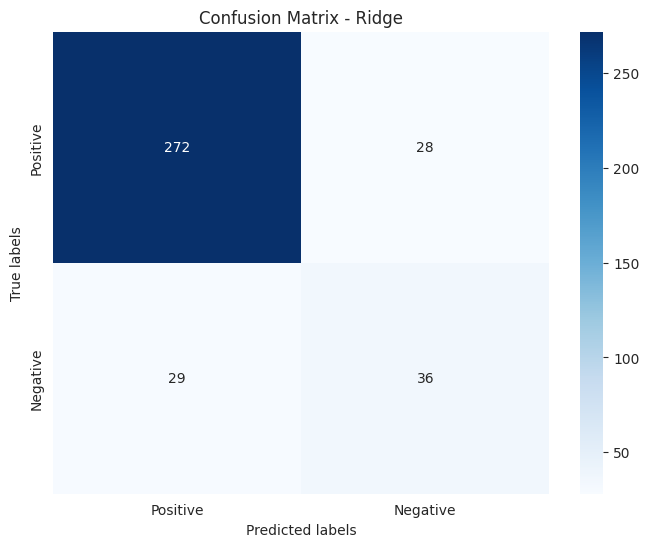

Classification Report:


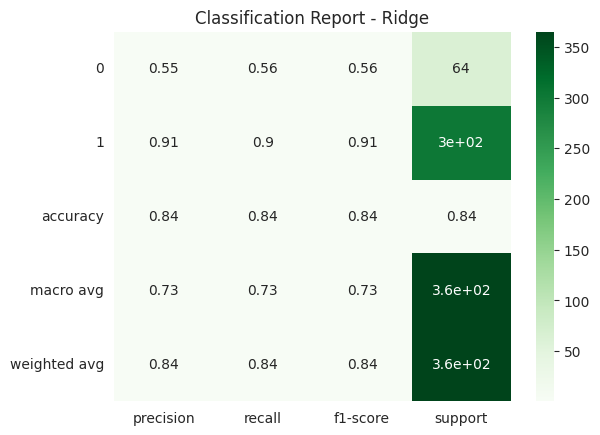

In [47]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train_01)  # Use binary labels for training
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute percentage error:", mape(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))

    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_01, y_pred_binary)  # Use binary labels for evaluation

    # Convert classification report to a dataframe for visualization
    cr_dict = classification_report(y_test_01, y_pred_binary, output_dict=True)
    cr_df = pd.DataFrame(cr_dict).transpose()

    # Plotting 2x2 confusion matrix
    tn, fp, fn, tp = cm.ravel()
    cm_2x2 = np.array([[tp, fp], [fn, tn]])  # Rearrange the matrix for a 2x2 format

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_2x2, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.yticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.show()

    print("Classification Report:")
    sns.heatmap(cr_df, annot=True, cmap="Greens")
    plt.title(f"Classification Report - {type(model).__name__}")
    plt.show()
    print()


From the above results, we can see that Gradient Boosting performed the best among all the models. Hence we set that as the second benchmark. Now lets see if we can improve its accuracy.

In [27]:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [28]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_train,y_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'huber', 'max_features': 'sqrt'} 

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt') 



In [29]:
X_train

array([[ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488, -1.00085668],
       [ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488, -0.50042834],
       [ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488,  0.        ],
       ...,
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  0.        ],
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  0.50042834],
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  1.00085668]])

In [30]:
start = time()
model = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt')
model.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time()-start
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute percentage error:", mape(y_test, y_pred))
print("\tR2 score:", r2_score(y_test, y_pred))

GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
	Training time: 0.072s
	Prediction time: 0.001s
	Explained variance: 0.5198270439612096
	Mean absolute percentage error: 0.1969245909972024
	R2 score: 0.36151914009839936


In [31]:
all_models = {}

for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(learning_rate = 0.05, loss = 'squared_error', max_features = 'sqrt', alpha=alpha)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

all_models["mse"] = gbr.fit(X_train, y_train)

In [32]:
y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)

In [33]:
mape(y_test, y_lower)

0.1965178911295512

This is the final version of the model, after hyperparameter optimization. Which will be used to predict the 2018 inventory (first 3 months)

#### Predicting the inventory requirement for the year 2018 (First 3 months)

In [34]:
Pred = pd.read_csv('/content/drive/MyDrive/ML Project/test.csv')
display(Pred.head())
display(Pred.tail())
Pred.shape

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


(45000, 4)

In [35]:
Pred = Pred[(Pred["store"] == 1) & (Pred["item"] == 1)]
Pred.shape

(90, 4)

In [36]:
parts = Pred["date"].str.split("-", n = 3, expand = True)
Pred["year"]= parts[0].astype('int')
Pred["month"]= parts[1].astype('int')
Pred["day"]= parts[2].astype('int')
Pred.head()

,id,date,store,item,year,month,day
0,0,2018-01-01,1,1,2018,1,1
1,1,2018-01-02,1,1,2018,1,2
2,2,2018-01-03,1,1,2018,1,3
3,3,2018-01-04,1,1,2018,1,4
4,4,2018-01-05,1,1,2018,1,5


In [37]:
Pred['weekend'] = Pred.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
Pred.head()

,id,date,store,item,year,month,day,weekend
0,0,2018-01-01,1,1,2018,1,1,0
1,1,2018-01-02,1,1,2018,1,2,0
2,2,2018-01-03,1,1,2018,1,3,0
3,3,2018-01-04,1,1,2018,1,4,0
4,4,2018-01-05,1,1,2018,1,5,0


In [38]:
Pred['m1'] = np.sin(Pred['month'] * (2 * np.pi / 12))
Pred['m2'] = np.cos(Pred['month'] * (2 * np.pi / 12))
Pred.head()

,id,date,store,item,year,month,day,weekend,m1,m2
0,0,2018-01-01,1,1,2018,1,1,0,0.5,0.866025
1,1,2018-01-02,1,1,2018,1,2,0,0.5,0.866025
2,2,2018-01-03,1,1,2018,1,3,0,0.5,0.866025
3,3,2018-01-04,1,1,2018,1,4,0,0.5,0.866025
4,4,2018-01-05,1,1,2018,1,5,0,0.5,0.866025


In [39]:
Pred.drop('date', axis=1, inplace=True)

In [40]:
Pred

,id,store,item,year,month,day,weekend,m1,m2
0,0,1,1,2018,1,1,0,0.5,8.660254e-01
1,1,1,1,2018,1,2,0,0.5,8.660254e-01
2,2,1,1,2018,1,3,0,0.5,8.660254e-01
3,3,1,1,2018,1,4,0,0.5,8.660254e-01
4,4,1,1,2018,1,5,0,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...
85,85,1,1,2018,3,27,0,1.0,6.123234e-17
86,86,1,1,2018,3,28,0,1.0,6.123234e-17
87,87,1,1,2018,3,29,0,1.0,6.123234e-17
88,88,1,1,2018,3,30,0,1.0,6.123234e-17


In [41]:
Pred.set_index("id", inplace = True)

In [42]:
Pred

,store,item,year,month,day,weekend,m1,m2
id,,,,,,,,
0,1,1,2018,1,1,0,0.5,8.660254e-01
1,1,1,2018,1,2,0,0.5,8.660254e-01
2,1,1,2018,1,3,0,0.5,8.660254e-01
3,1,1,2018,1,4,0,0.5,8.660254e-01
4,1,1,2018,1,5,0,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...
85,1,1,2018,3,27,0,1.0,6.123234e-17
86,1,1,2018,3,28,0,1.0,6.123234e-17
87,1,1,2018,3,29,0,1.0,6.123234e-17


Formatted Prediction:
[26.82, 26.82, 26.82, 26.82, 26.82, 22.93, 22.93, 26.82, 26.82, 26.82,
 26.82, 26.82, 22.93, 22.93, 26.82, 26.82, 26.82, 26.82, 26.82, 24.8 ,
 24.8 , 29.04, 29.04, 29.04, 29.04, 29.04, 24.8 , 24.8 , 29.04, 29.04,
 29.04, 20.55, 20.55, 17.13, 17.13, 20.55, 20.55, 20.55, 20.55, 20.55,
 17.13, 17.13, 20.55, 20.55, 20.55, 20.55, 20.55, 17.13, 17.13, 20.55,
 22.55, 22.55, 22.55, 22.55, 18.89, 18.89, 22.55, 22.55, 22.55, 16.91,
 16.91, 14.15, 14.15, 16.91, 16.91, 16.91, 16.91, 16.91, 14.15, 14.15,
 16.91, 16.91, 16.91, 16.91, 16.91, 14.15, 14.15, 16.91, 19.47, 19.47,
 19.47, 19.47, 16.81, 16.81, 19.47, 19.47, 19.47, 19.47, 19.47, 16.81]
Size: 90


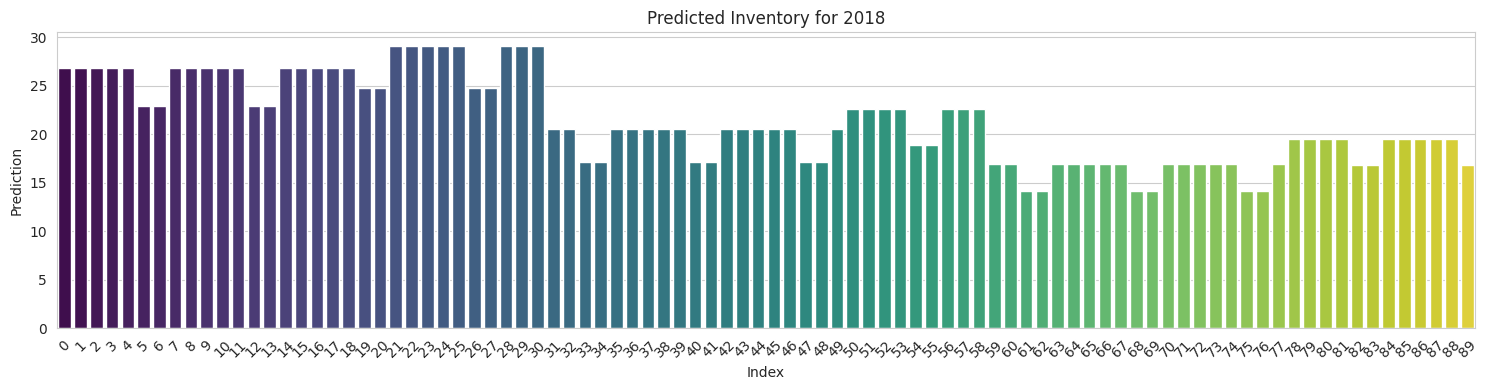

In [68]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming Pred is your data for prediction
scaler = StandardScaler()
Pred = scaler.fit_transform(Pred)

# Predicting with the trained model
Pred_Y = model.predict(Pred)

formatted_pred = np.array2string(Pred_Y, precision=2, separator=', ', suppress_small=True)

# Print the formatted prediction
print("Formatted Prediction:")
print(formatted_pred)
print("Size:", Pred_Y.size)

# Create a seaborn style plot for better visualization
sns.set_style("whitegrid")
plt.figure(figsize=(15, 4))
sns.barplot(x=np.arange(len(Pred_Y)), y=Pred_Y, palette="viridis")
plt.xlabel("Index")
plt.ylabel("Prediction")
plt.title("Predicted Inventory for 2018")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle

# Load the trained machine learning model
model = pickle.load(open('model.pkl', 'rb'))

# Prepare input data for the specific day
specific_day_data = pd.DataFrame({
    'day': [23],          # Specify the day
    'month': [2],         # Specify the month (e.g., January)
    'year': [2018],
    'm1': [np.sin(2 * (2 * np.pi / 12))],  # Sine of the month to capture cyclic nature
    'm2': [np.cos(2 * (2 * np.pi / 12))],  # Cosine of the month to capture cyclic nature
    'weekday': [5],       # Specify the day of the week (0 for Monday, 1 for Tuesday, ..., 6 for Sunday)
    'store': [1],         # Specify the store number
    'item': [1]           # Specify the item number
})

# Standardize the input data
scaler = StandardScaler()
specific_day_data_scaled = scaler.fit_transform(specific_day_data)

# Predict the inventory demand for the specific day
inventory_demand = model.predict(specific_day_data_scaled)

# Print the predicted inventory demand
print("Predicted inventory demand for the specific day of 2018:", inventory_demand)


Predicted inventory demand for the specific day of 2018: [18.29316568]


## Thank You!